In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

def load_and_preprocess_image_array(image_array, target_size):
    image_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    preprocessed_images = []
    for image in image_array:
        image = image_transform(image).unsqueeze(0)
        preprocessed_images.append(image)

    return torch.cat(preprocessed_images, dim=0)

def extract_style_vectors(image_array, target_size=(224, 224)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    _model = models.vgg19(pretrained=True).features.to(device)
    _model = nn.Sequential(*list(_model.children())[:35])

    images = load_and_preprocess_image_array(image_array, target_size).to(device)
    with torch.no_grad():
        style_vectors = _model(images)
    style_vectors = style_vectors.view(style_vectors.size(0), -1)
    return style_vectors

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    magnitude1 = torch.norm(vector1)
    magnitude2 = torch.norm(vector2)
    similarity = dot_product / (magnitude1 * magnitude2)
    return similarity.item()

def compare_to_set(image_array, target_size=(224, 224)):
    style_vectors = extract_style_vectors(image_array, target_size)

    similarity_matrix = torch.zeros(len(image_array), len(image_array))
    for i in range(style_vectors.size(0)):
        for j in range(style_vectors.size(0)):
            similarity = cosine_similarity(style_vectors[i], style_vectors[j])
            likeness = 1.0 - similarity  # Invert the likeness to get dissimilarity
            likeness = min(1,max(0, likeness))  # Clip the likeness to [0,1]
            if likeness < 0.01:
                likeness = 0
            similarity_matrix[i][j] = likeness

    return similarity_matrix.tolist()

def calculate_mean_dissimilarity(dissimilarity_matrix):
    num_images = len(dissimilarity_matrix)
    mean_dissimilarities = []

    for i in range(num_images):
        dissimilarity_values = [dissimilarity_matrix[i][j] for j in range(num_images) if i != j]
        mean_dissimilarity = sum(dissimilarity_values) / len(dissimilarity_values)
        mean_dissimilarities.append(mean_dissimilarity)

     # Min-max normalization
    min_value = min(mean_dissimilarities)
    max_value = max(mean_dissimilarities)
    range_value = max_value - min_value
    if range_value != 0:
        mean_dissimilarities = [(value - min_value) / range_value for value in mean_dissimilarities]
    else:
        # All elements are the same (no range), set all values to 0.5
        mean_dissimilarities = [0.5] * num_images

    # Ensure sum of values is 1 (normalize)
    sum_values = sum(mean_dissimilarities)
    if sum_values != 0:
        mean_dissimilarities = [value / sum_values for value in mean_dissimilarities]

    return mean_dissimilarities

# if __name__ == "__main__":
#     image1_path = "path/to/image1.jpg"
#     image2_path = "path/to/image2.jpg"

#     style_vector1 = extract_style_vector(image1_path)
#     style_vector2 = extract_style_vector(image2_path)

#     similarity_score = cosine_similarity(style_vector1, style_vector2)
#     print(f"Cosine similarity between the style vectors: {similarity_score}")


In [81]:
# Stable diffusion
import torch
import transformers
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline

# Lets instantiate the stable diffusion model.
model =  StableDiffusionPipeline.from_pretrained( "prompthero/openjourney-v4", custom_pipeline="lpw_stable_diffusion", torch_dtype=torch.float16, safety_checker=None ).to('cuda')


/home/creativebuilds/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
You have disabled the safety checker for <class 'diffusers_modules.git.lpw_stable_diffusion.StableDiffusionLongPromptWeightingPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [20]:
outputs = model(prompt="A sunny day", num_images_per_prompt=2).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [74]:
outputs2 = model(prompt="A sunny day", num_images_per_prompt=2).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [78]:
outputs3 = model(prompt="A sunny day", num_images_per_prompt=2).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [82]:
outputs4 = model(prompt="A sunny day", num_images_per_prompt=2).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [83]:
out = calculate_mean_dissimilarity(compare_to_set([*outputs, *outputs2, *outputs3, *outputs4]))
print(out)

[0.036788332140758155, 0.22806136021293041, 0.0, 0.10219606117210635, 0.07936256953248323, 0.12096000872599659, 0.2956353145478528, 0.13699635366787244]


In [35]:
out

[0.7012262543042501, 0.6564069787661234, 0.643791397412618, 0.6900493303934733]

In [16]:
from fabric.utils import get_free_gpu, tile_images

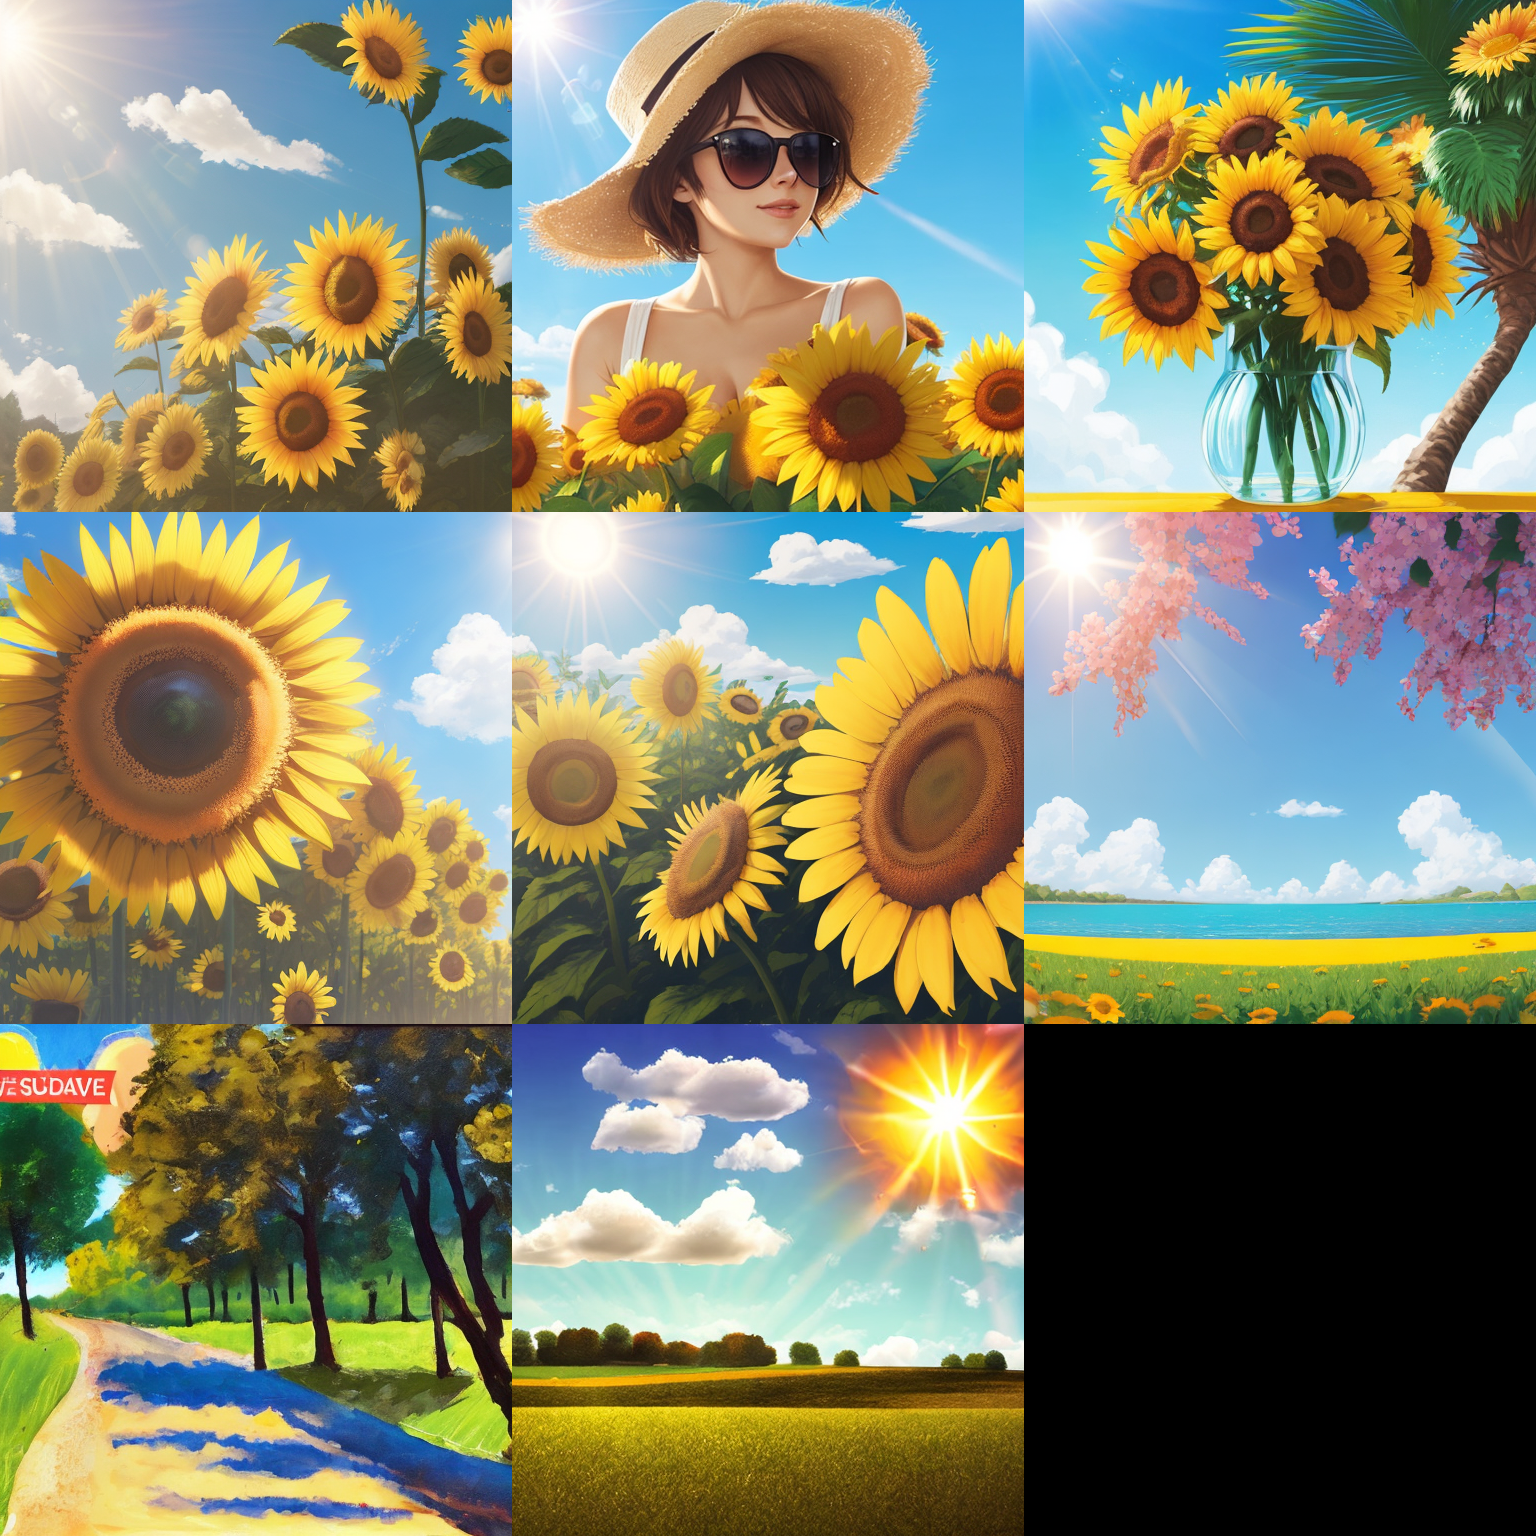

In [85]:
tile_images([*outputs, *outputs2, *outputs3, *outputs4])